# Test on Genetic Algorithm

About GA: https://en.wikipedia.org/wiki/Genetic_algorithm (there is a picture of antenna-design using this algorithm)

my homework code (5 years ago): https://ridlow.wordpress.com/?s=genetic

<hr>
<hr>
**Short explanation**

1. Optimization problem solved by this 'kind' of method (metaheuristics, stochastic) -> find the best parameters for our problem/function, in this case our problem is non differentiable, so we can not use standard method like Gradient descent or Newton. In simpler way, exploring the set of parameters can be done by chose it 'randomly' or with a 'grid' in possible region. But we want to make *a smarter way* of exploring these set of parameters. Genetic algorithm is one of this algorithm.

2. In genetic algorithm (GA), a set of parameters is called "individual"/"genotype"/"chromosome", e.g. can be an array of parameters [1, 0.75, 1.5, 0.5, 0.2, 1.2, 0.1], binary form, or other form (tree, path, etc).

3. Value that we want to optimize (minimize or maximize) is called "fitness".

4. For starter (initialization), we need to generate *a set of individual* which is called "population". We can decide the number of individual in our population, e.g. 10, 20, 100, or 1000...

5. After initialization of population (our first "generation"), we will "evolve" this population by doing some steps which mimic the evolution in nature.

6. Standard/simple evolutional process to generate "next generation" (new population) are:
    
    + SELECTION, a process to select individual that will "survive" for next process. Simple selection can be done by roullete -> for each individual --- generate random number --- if random number > tolerance --- this individual is survive. This "tolerance" can be made base on "fitness" value of that individual -> hence good individual should have larger chance to survive, but the bad individual still can survive.
    
    + CROSSOVER, individuals that survive from "natural selection" can "married" and make an "offspring", simplest way to do "crossover" -> select pair of individual (randomly) --- for each individual in a pair, devide it, crossover the result e.g. [1, 2, 3, 4, 5] x [2, 3, 5, 1, 2] -> [1, 2, 3, 1, 2] and [2, 3, 5, 4, 5]. So the result is 2 offspring from 2 parent.
    
    + MUTATION, "offspring" from the crossover process is inheriting the "parent", but there is a chance that the offspring can have different "DNA" from the process called mutation. For each offspring --- generate random number --- if randomnumber > mutationprobability --- mutate this "offspring"
    
    All of the process above using "random number" to do anything (stochastic) -> select or not, crossover or not, where to "chop" the DNA, mutate or not, where is the place to do mutation, and doing mutation.

7. After a set of "evolution process" above, we will get new generation (new population). Iterate the process, and surely we will always get the best "individual".

8. In this "kind" of algorithm we always get the best "parameters"/individual, but it is *not guaranteed* that those parameter is "really the best"!

9. Therefore, as other stochastic type algorithm, we need to do more than one for the same problem.


Those are short/basic explanation of GA. Of course there are more advance terms, e.g. how we can make GA better for multi-objective -- more than one objective (example: in scheduling, maximize observing time but also minimize changing of configuration) -- https://en.wikipedia.org/wiki/Multi-objective_optimization, Pareto, NSGA-II, SPEA2, MO-CMA-ES. Genetic Programming for AI, etc.

<hr>
<hr>

### DEAP (Distributed Evolutionary Algorithms in Python)

We want to try using DEAP (https://github.com/DEAP/deap), it is not just a package, it is "a framework" -> encourage the user to modify and make his own 'evolution' process.

In this framework they already provide many advance method (that I don't understand ;) )

With this framework, we can also construct different 'evolution' algorithm such as *Differential Evolution* or *Particle Swarm Optimization*

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

from deap import base, creator, tools, algorithms # import DEAP

%matplotlib inline

### First test

For the first test, we will try to optimize this simple problem (a mimic of our weighting problem). 

There are 10 parameters -> individual: $[i_0, i_1, i_2, \ldots, i_{9}]$

and the parameters, $i$, is random number from 0 to 1

**Optimize**:

$$f(i) = -0.5 i_0 + 2 i_1 + 3 i_2 + 0.001 i_3 + i_4 + \ldots + i_{9}$$


just a summation problem.

What I mean by mimicing is:

- $i_0$ is like a 'problematic MS'
- $i_1$ and $i_2$ are best MS
- $i_3$ is MS that can be ignored (worthless)
- $i_4, \ldots, i_9$ are like typical MS

Solution:

We know the solution of this problem, because of $i$ is random number from 0 to 1, so the optimum solution would be:

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1] with fitness value = 11.001

Note:

- $i_0$ must convergent to 0
- $i_1$, $i_2$ must convergent to 1 
- $i_4, i_5, \ldots, i_9$ also must convergent to 1
- $i_3$ will be slowly convergent (or maybe divergent)

In [2]:
def function_to_evaluate(ind):  
    '''Function that we want to optimize -> to calculate fitness'''
    return -0.5*ind[0] + 2*ind[1] + 3*ind[2] + 0*ind[3] + sum(ind[4:]),

In here, the problem is to "maximize" the fitness value

In [3]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

Note:
- we can change it to minimization problem by changing the weights=(-1.0,)
- we actually can use more than one 'function' as a fitness test, e.g. **minimize the number of MS** and **maximize the RMS**, but I still don't quite understand/know how to do that yet, and whether if it is worthy or not in our case.

Next, set the evolution step/process/genetic operators

- We use "uniform" random number generator to generate $i$ or to mutate it -> we can use different PDF (if we have preference to some values)

- We set the number of DNA/parameter in an individu/chromosom = 10 (e.g. weight of 10 MS)

- Set the crossover method, selection method, and probability of mutation happen in population

In [4]:
toolbox = base.Toolbox()

toolbox.register("attr_bool", random.random) # function random.random as input 
# uniform random 0 to 1 as 'individu generator'

# number of parameter (e.g. 10 MS)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=10) 
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", function_to_evaluate) # insert the function name here.
toolbox.register("mate", tools.cxTwoPoint) # how to do crossover
toolbox.register("mutate", tools.mutFlipBit, indpb=0.10) # probability of individu get a mutation
toolbox.register("select", tools.selTournament, tournsize=3) # tournament type "selection" before "mating process"

<hr><hr>

**Main process**: generate first population/generation and do GA iteration

In DEAP there are some functions that can be used, 
- for convenient such as LogBook, Statistics, and Hall-Of-Fame.

- several standard algorithm (a set of evolution process) that can be used directly (http://deap.readthedocs.io/en/master/api/algo.html).

- for each process (selection, crossover, mutation) they also provide several method that we can choose (http://deap.readthedocs.io/en/master/api/tools.htm)

<hr>
<hr> 
We insert one "best guest" in the first population.

an individu: [0.1, 0.8, 0.8, 0.1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

- we will insert our best guess in real case with calculated/predicted weight value of e.g. $1/rms^2$

In [5]:
def main(number_of_ind=39, number_of_generation=10, cxpb=0.5, mutpb=0.2):
    pop = toolbox.population(n=number_of_ind)
    
    # insert a "woho" -> best guess
    some_woho_individual = creator.Individual([0.1, 0.8, 0.8, 0.1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
    pop.append(some_woho_individual)
    
    # real number of individual in population is number_of_ind + 1
    
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    # cxpb = crossover probability
    # mutpb = mutation probability
    # ngen = number of generation -> GA iteration
    
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=number_of_generation, 
                                       stats=stats, halloffame=hof, verbose=True)
    
    return pop, logbook, hof

Run 
- number of individu in a population is 40 
- number of generation/evolution/GA iteration = 10
- selection process = "Tournament method" with 3 individu for each tournament
- crossover probability = 0.5, method cxTwoPoint (I think an individu is chop in two point before crossing)
- probability of an "offspring" get a mutation = 0.1
- mutation probability for each DNA/parameter = 0.2

In [6]:
pop, log, hof = main(39, 10)
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))

gen	nevals	avg    	min    	max   
0  	40    	5.10794	2.40391	8.2216
1  	22    	5.93212	4.08453	8.13678
2  	22    	6.80291	5.10326	8.18247
3  	21    	7.31375	4.26413	8.18247
4  	24    	7.8274 	4.97383	8.59469
5  	20    	8.16562	7.19325	9.01251
6  	21    	8.20853	4.89177	9.01251
7  	27    	8.42356	4.22646	9.08671
8  	21    	8.47576	5.11765	9.37559
9  	17    	8.76779	5.80091	9.37559
10 	23    	8.89225	6.02864	9.37559
Best individual is: [0.2348586090495658, 0.9595698717112172, 0.9946231453830758, 0.0, 0.9272358518897357, 0.9653953402794174, 0.24953797801241828, 0.9126398077497287, 0.9109825452611281, 0.6242138729648767]
with fitness: (9.375585271204184,)


Plot the statistics of population for every generation/GA step

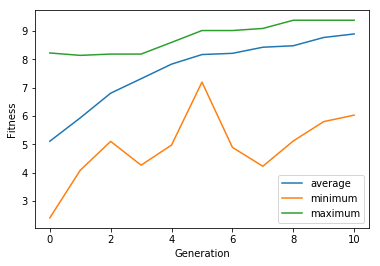

In [7]:
gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

We can see that the best individu from all generation has $i_0$ and $i_3$ close to 0, and the other is close to 1.

After several testing, 
- size of population is more important than number of GA iteration/generation
- somehow it is not sensitive to mutation probability

<hr><hr><hr>
In GA, if we set mutation probability to 1, that means it is same like "bruto force" montecarlo.

Let see the number of iteration if we are using "Bruto force monte carlo" to explore the parameters

In [8]:
individu = np.random.random(10)

niter = 1

while function_to_evaluate(individu)[0] < 10:
    individu = np.random.random(10)
    niter += 1

print individu
print function_to_evaluate(individu)
print "Number of iteration: ", niter

[ 0.04980037  0.98234745  0.91677827  0.48244675  0.72848892  0.87747208
  0.93739292  0.98469019  0.94798609  0.88310764]
(10.049267378768707,)
Number of iteration:  1883372


- If **lucky** we can get a good result with fewer iteration, but if not lucky then it can take quite a long time. (algorithm that depend on the luck is bad, or, is it 'algorithm'?)

- For some problem (e.g. large number of parameters, multi-objective) it is impossible to get a good solution within "the age of universe" scale -> this is the reason of these metaheuristic algorithm born.

<hr>
<hr>

**Next**

in practice we can remove the "bad MS" if the weight is too small, but maybe there is a case like $i_3$ above which is divergent (not affecting much, whether we give small or big weight). 

Therefore, I want to see,
- can we see how each parameter ($i_j$) from *best individu in each generation* change over the iteration? 
- If so, can we see that $i_0$ will converge to 0, $i_3$ will diverge, and other converge to 1?
- If that the case, then it is possible to get rid the "bad MS" by looking at 'this' (weight converge to 0 or divergen).

Lets modify "main" so we can get this data, using same test problem above.

In [9]:
import multiprocessing
pool = multiprocessing.Pool()

toolbox.register("map", pool.map)

In [46]:
def main(number_of_ind=39, number_of_generation=10, cxpb=0.5, mutpb=0.2, verbose=False):
    pop = toolbox.population(n=number_of_ind)
    # insert a "woho" -> best guest
    some_woho_individual = creator.Individual([0.1, 0.8, 0.8, 0.1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
    pop.append(some_woho_individual)
    # real number of individual in population is number_of_ind + 1

    # calculate fitness for the 0th generation
    invalids = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalids) # parallelization on solving the "objective function"
    for ind, fit in zip(invalids, fitnesses):
        ind.fitness.values = fit
    
    # initiate logging
    # Hall of Fame
    hof = tools.HallOfFame(1) # save the best of the best, only 1 individu
    # Statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)
    # Log book
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + stats.fields
    
    # logging
    record = stats.compile(pop)
    logbook.record(gen=0, nevals=len(invalids), **record)
    if verbose:
        print logbook.stream

    total_evals = len(invalids)
    best = []
    best.append(tools.selBest(pop, k=1)[0])
        
    for gen in range(1, number_of_generation+1): # iteration
        # Select the next generation individuals
        offspring = toolbox.select(pop, k=len(pop))
        
        # Vary the pool of individuals
        # inside: crossover AND mutation
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # some individual are "new" offspring, others are still the same parent 
        # e.g. not selected in crossover and also not a mutan
        # if fitness is "invalid", not calculated yet (real offspring) -> calculate fitness..
        invalids = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalids)
        for ind, fit in zip(invalids, fitnesses):
            ind.fitness.values = fit
        
        # Replace the current population by the offspring
        pop[:] = offspring
        
        # Update the hall of fame with the generated individuals
        hof.update(pop)

        # logging
        record = stats.compile(pop)
        logbook.record(gen=gen, nevals=len(invalids), **record)
        total_evals += len(invalids)
        if verbose:
            print logbook.stream
    
        best.append(tools.selBest(pop, k=1)[0])
    
    return pop, logbook, hof, best, total_evals

I make high mutation probability

Best individual is: [0.0, 0.9427922319103642, 1.0, 0.0, 1.0, 1.0, 1.0, 0.9975794918615434, 1.0, 1.0]
with fitness: (10.88316395568227,)
Total evaluation of objective function:  1826


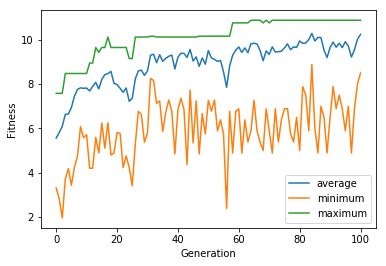

In [47]:
pop, log, hof, best, total_evals = main(19, 100, cxpb=0.5, mutpb=0.8)
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
print "Total evaluation of objective function: ", total_evals

gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

In [48]:
b = np.array(best)
pars = b.T
iteration = np.arange(len(pars[0]))

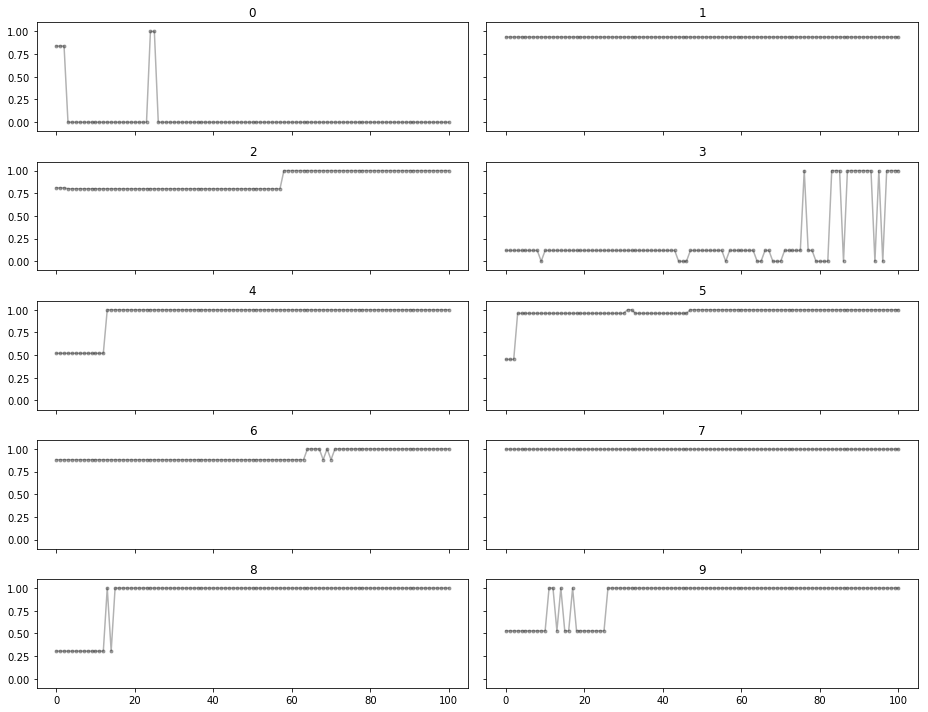

In [49]:
fig, axs = plt.subplots(5,2, figsize=(13,10), sharex=True, sharey=True)
axs = axs.flat

for i, par in enumerate(pars):
    axs[i].plot(iteration, par, 'k.-', alpha=0.3)
    axs[i].set_ylim([-0.1,1.1])
    axs[i].set_title(str(i))
    fig.tight_layout()

As we predicted:

- $i_1$ convergent to 0

- $i_3$ is divergent

- others convergent to 1

In [56]:
np.savetxt('test.out', best, delimiter=' ')